In [2]:
import json
import numpy as np
from skimage.io import imread, imshow
from skimage import transform
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math
import pandas as pd
from pathlib import Path
import open3d as o3d
import os

In [3]:
def read_json_file(json_path):
    with open(json_path, 'r') as f:
        content = json.load(f)
    return content


def write_json_file(anno, json_path):
    with open(json_path, 'w') as f:
        json.dump(anno, f)

def get_bboxes_from_via_anno_file(via_json_path, key_src='depth'):
    anno = read_json_file(via_json_path)
    dest_point_list = []
    src_point_list = []
    file_name_list = list(anno.keys())
    for anno_key in anno.keys():
        if key_src in anno_key:
            for point_info in anno[anno_key]['regions']:
                dest_point_list.append([point_info['shape_attributes']['cx'], point_info['shape_attributes']['cy']])
        else:
            for point_info in anno[anno_key]['regions']:
                src_point_list.append([point_info['shape_attributes']['cx'], point_info['shape_attributes']['cy']])
    return [src_point_list, dest_point_list]

def get_point_from_via_file(via_json_path):
    src_point_list, dest_point_list = get_bboxes_from_via_anno_file(via_json_path)
    np_src_point_list = np.asarray(src_point_list)
    np_dest_point_list = np.asarray(dest_point_list)
    return [np_src_point_list, np_dest_point_list]

In [4]:
def parse_polybboxes(anno):
    poly_points = []
    for key, anno_info in anno.items():
        poly_info_list = anno_info["regions"]
        # print(poly_info_list[0])
        for poly_info in poly_info_list:
            x_point_list = poly_info["shape_attributes"]["all_points_x"]
            y_point_list = poly_info["shape_attributes"]["all_points_y"]
            points = np.stack((x_point_list, y_point_list), axis=-1)
            poly_points.append(points)
    return poly_points

In [5]:

def mapping(anno_register_file, np_src_point_list, np_dest_point_list):
    tform = transform.estimate_transform('projective', np_src_point_list, np_dest_point_list)
    anno = read_json_file(anno_register_file)
    bboxes_list = parse_polybboxes(anno)
    np_bboxes = np.asarray(bboxes_list)
    np_dest_bboxes = []
    for poly_points in np_bboxes:
        np_dest_bboxes.append(tform(poly_points))
    return [np_dest_bboxes, np_bboxes]


def mapping_v2(np_bboxes_list, np_src_point_list, np_dest_point_list):
    tform = transform.estimate_transform('projective', np_src_point_list, np_dest_point_list)
    np_dest_bboxes = []
    for poly_points in np_bboxes_list:
        np_dest_bboxes.append(tform(poly_points))
    return np_dest_bboxes

def get_bboxes_from_2d_anno(anno_register_file):
    anno = read_json_file(anno_register_file)
    bboxes_list = parse_polybboxes(anno)
    np_bboxes = np.asarray(bboxes_list)
    return np_bboxes

def shrink_or_swell_shapely_polygon(my_polygon, factor=0.10, swell=True, return_np=True):
    ''' returns the shapely polygon which is smaller or bigger by passed factor.
        If swell = True , then it returns bigger polygon, else smaller '''
    from shapely import geometry

    #my_polygon = mask2poly['geometry'][120]

    # shrink_factor = 0.10 #Shrink by 10%
    xs = list(my_polygon.exterior.coords.xy[0])
    ys = list(my_polygon.exterior.coords.xy[1])
    x_center = 0.5 * min(xs) + 0.5 * max(xs)
    y_center = 0.5 * min(ys) + 0.5 * max(ys)
    min_corner = geometry.Point(min(xs), min(ys))
    max_corner = geometry.Point(max(xs), max(ys))
    center = geometry.Point(x_center, y_center)
    shrink_distance = center.distance(min_corner)*factor

    if swell:
        my_polygon_resized = my_polygon.buffer(shrink_distance) #expand
    else:
        my_polygon_resized = my_polygon.buffer(-shrink_distance) #shrink

    if return_np:
      return my_polygon_resized, np.array(my_polygon_resized.exterior.xy).T
    return my_polygon_resized

def expand_polygon(poly_points_list, factor=0.1, swell=True):
    from shapely.geometry import Polygon
    new_poly_points_list = []
    for poly_points in poly_points_list:
        p = Polygon(list(zip(poly_points[:, 0], poly_points[:, 1])))
        _, new_poly_points = shrink_or_swell_shapely_polygon(p, factor=factor, swell=swell)
        new_poly_points_list.append(new_poly_points)
    return new_poly_points_list

def draw_anno_on_image(polyboxes_list, img, color=(255, 0, 0),  thickness=2):
    for polybox in polyboxes_list:
        np_polybox = polybox.astype(int)
        img = cv2.polylines(img, [np_polybox], True, color, thickness)
    return img

In [24]:
# via_json_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/registering_points_anno/08360a_1.json"
# anno_register_file = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/anno_2d/08360a_3.json"
# depth_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/depths/08360_kho_khuon_in_1_r_depth.png"
via_json_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/registering_points_anno/26774_1.json"
anno_register_file = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/anno_2d/26774a_4.json"
depth_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/depths/26774_kho_khuon_in_1_r_depth.png"

In [25]:
[np_src_point_list, np_dest_point_list] = get_point_from_via_file(via_json_path)
dest_poly_points_list, origin_poly_points_list = mapping(anno_register_file, np_src_point_list, np_dest_point_list)
new_dest_poly_points_list = expand_polygon(dest_poly_points_list)
origin_img = cv2.imread(depth_img_path)
# img = draw_anno_on_image(dest_poly_points_list, origin_img)
# img = draw_anno_on_image(new_dest_poly_points_list, img, color=(255, 255, 0))
# cv2.imwrite("./output.png", img)

/tmp/ipykernel_249188/647407489.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_bboxes = np.asarray(bboxes_list)


In [6]:
def draw_anno_on_img(via_json_path, anno_register_file, depth_img_path, expand_poly=True):
    [np_src_point_list, np_dest_point_list] = get_point_from_via_file(via_json_path)
    dest_poly_points_list, poly_points_list = mapping(anno_register_file, np_src_point_list, np_dest_point_list)
    new_dest_poly_points_list = expand_polygon(dest_poly_points_list)
    img = cv2.imread(depth_img_path)
    img = draw_anno_on_image(dest_poly_points_list, img)
    img = draw_anno_on_image(new_dest_poly_points_list, img, color=(255, 255, 0))
    return img

In [9]:
# via_json_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/registering_points_anno/26774_1.json"
# anno_register_file = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/anno_2d/26774a_4.json"
# depth_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/depths/26774_kho_khuon_in_1_r_depth.png"

In [419]:
# print_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/mocban_img_2d/08465a_4.jpg"
# depth_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/depths/08465_kho_khuon_in_2_r_depth.png"
# via_json_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/registering_points_anno/08465_2.json"
# anno_register_file = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/anno_2d/08465a_4.json"

print_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/mocban_img_2d/29141b_4.jpg"
depth_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/depths/29141_kho_khuon_in_2_r_depth.png"
via_json_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/registering_points_anno/29141_2.json" 
anno_register_file = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/anno_2d/29141a_4.json"

In [420]:
img = draw_anno_on_img(via_json_path, anno_register_file, depth_img_path, expand_poly=True)

/tmp/ipykernel_185519/2297659784.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_bboxes = np.asarray(bboxes_list)


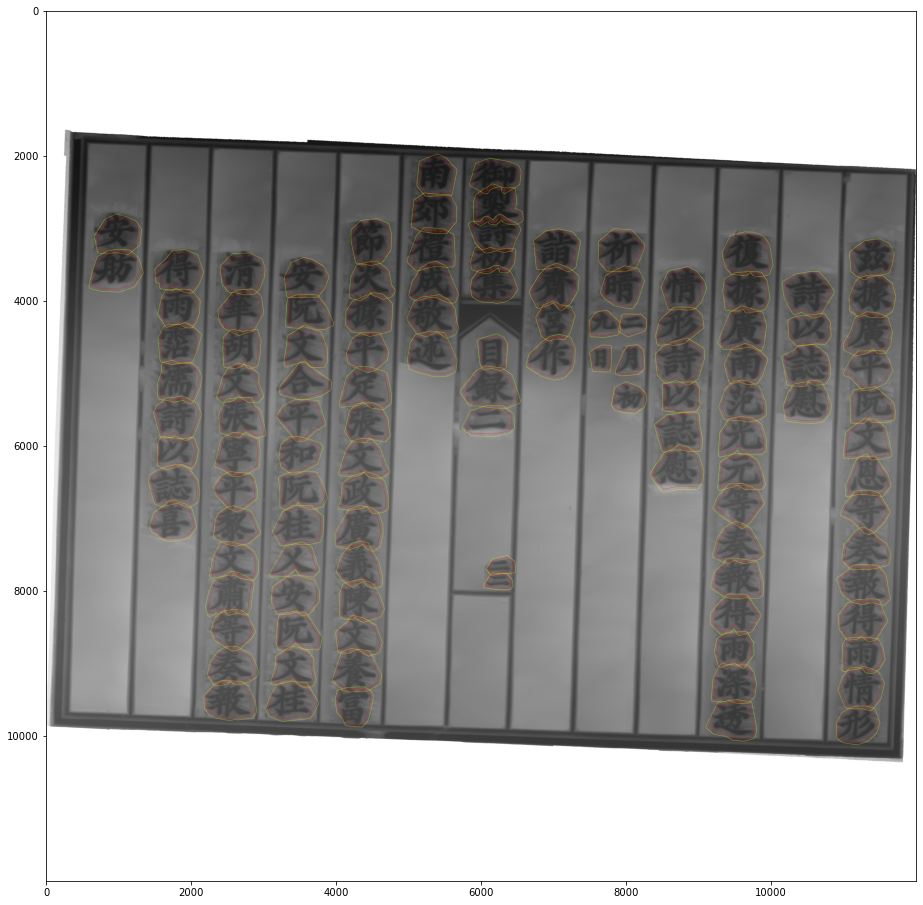

In [421]:
plt.figure(figsize=(18, 16))
plt.imshow(img);

In [6]:
def crop_img(img, pts):
# # img = cv2.imread("test.png")
# pts = np.array([[10,150],[150,100],[300,150],[350,100],[310,20],[35,10]])
    pts = np.array(pts, dtype=np.int32)
    ## (1) Crop the bounding rect
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w].copy()

    ## (2) make mask
    pts = pts - pts.min(axis=0)

    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)

    ## (3) do bit-op
    dst = cv2.bitwise_and(croped, croped, mask=mask)

    ## (4) add the white background
    bg = np.ones_like(croped, np.uint8)*255
    cv2.bitwise_not(bg,bg, mask=mask)
    dst2 = bg + dst
    return dst2

def get_rotation_degree(vec_1, vec_2):
    counterwise_lock_degree = np.arctan2(vec_1[0]*vec_2[1] - vec_1[1]*vec_2[0], vec_1[0]*vec_2[0] + vec_1[1]*vec_2[1])
    return math.degrees(counterwise_lock_degree)

def get_rad(pivot_points, start_index_point=0, end_index_point=2, unit_vec=[1, 0]):
    start_points, end_points = pivot_points[start_index_point], pivot_points[end_index_point]
    woodblock_vec = end_points - start_points
    counterwise_clock_degree = get_rotation_degree(unit_vec, woodblock_vec)
    return counterwise_clock_degree

def get_rotated_img(img, pivot_points, start_index_point=0, end_index_point=1, unit_vec=[1, 0]):
    counterwise_lock_degree = get_rad(pivot_points, start_index_point=start_index_point, end_index_point=end_index_point, unit_vec=unit_vec)
    (h, w) = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), counterwise_lock_degree, 1.0)
    rotated_img = cv2.warpAffine(img, M, (w, h), borderValue=(255,255,255))
    return [rotated_img, M]

def get_rotation_points(poly_points, M):
    homo_poly_points = np.column_stack((poly_points, np.ones((len(poly_points), 1))))
    transform_poly_points = np.dot(M, homo_poly_points.T)
    transform_poly_points = transform_poly_points.T
    return transform_poly_points

In [403]:
# print_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/mocban_img_2d/08465a_4.jpg"
# depth_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/depths/08465_kho_khuon_in_2_r_depth.png"
# via_json_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/registering_points_anno/08465_2.json"
# anno_register_file = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/anno_2d/08465a_4.json"

# via_json_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/registering_points_anno/26774_1.json"
# anno_register_file = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/anno_2d/26774a_4.json"
# depth_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/depths/26774_kho_khuon_in_1_r_depth.png"
# print_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/mocban_img_2d/26774a_4.jpg"

print_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/mocban_img_2d/29141b_4.jpg"
depth_img_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/depths/29141_kho_khuon_in_2_r_depth.png"
via_json_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/registering_points_anno/29141_2.json" 
anno_register_file = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/anno_2d/29141b_4.json"

In [404]:
# print_img = cv2.imread("/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/mocban_img_2d/26774a_4.jpg")
# depth_img = cv2.imread("/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/depths/26774_kho_khuon_in_1_r_depth.png")
print_img = cv2.imread(print_img_path)
depth_img = cv2.imread(depth_img_path)

In [405]:
import copy

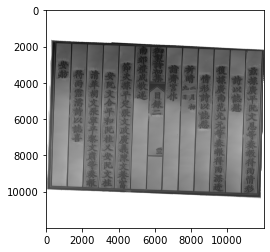

In [406]:
plt.imshow(depth_img);

In [407]:
# via_json_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/registering_points_anno/26774_1.json"
# a_json_path = "/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/registering_points_anno/08465_1.json"
[np_src_point_list, np_dest_point_list] = get_point_from_via_file(via_json_path)
dest_poly_points_list, origin_poly_points_list = mapping(anno_register_file, np_src_point_list, np_dest_point_list)

/tmp/ipykernel_185519/2297659784.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_bboxes = np.asarray(bboxes_list)


(6, 2)

In [377]:
p1, p2 = np_dest_point_list[0], np_dest_point_list[1] 

In [408]:
counterwise_clock_degree = get_rad(np_dest_point_list, start_index_point=0, end_index_point=1, unit_vec=[1, 0])

In [409]:
counterwise_clock_degree

2.32057306345391

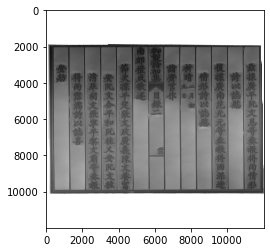

In [410]:
(h, w) = depth_img.shape[:2]
M = cv2.getRotationMatrix2D((w//2, h//2), counterwise_clock_degree, 1.0)
rotated_img = cv2.warpAffine(copy.deepcopy(depth_img), M, (w, h), borderValue=(255,255,255))
plt.imshow(rotated_img);

In [411]:
rotated_print_img, M_print = get_rotated_img(print_img, np_src_point_list)
rotated_depth_img, M_depth = get_rotated_img(depth_img, np_dest_point_list)

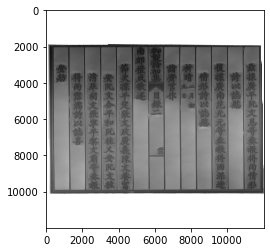

In [412]:
plt.imshow(rotated_depth_img);

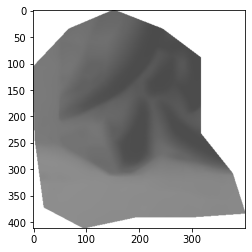

In [413]:
# dest_poly_points_list, origin_poly_points_list
dest_transform_poly_points = get_rotation_points(dest_poly_points_list[10], M_depth)
depth_dst = crop_img(rotated_depth_img, dest_transform_poly_points)
# depth_dst = crop_img(depth_img, dest_poly_points_list[30])
plt.imshow(depth_dst);

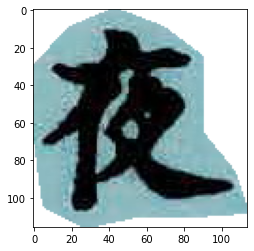

In [415]:
# original_transform_poly_points = get_rotation_points(origin_poly_points_list[10], M_print)
# print_dst = crop_img(rotated_print_img, original_transform_poly_points)
print_dst = crop_img(print_img, origin_poly_points_list[10])
plt.imshow(print_dst);

In [93]:
height, width = depth_dst.shape[:2]
resize_print_img = cv2.resize(print_dst, (width, height), interpolation = cv2.INTER_AREA)

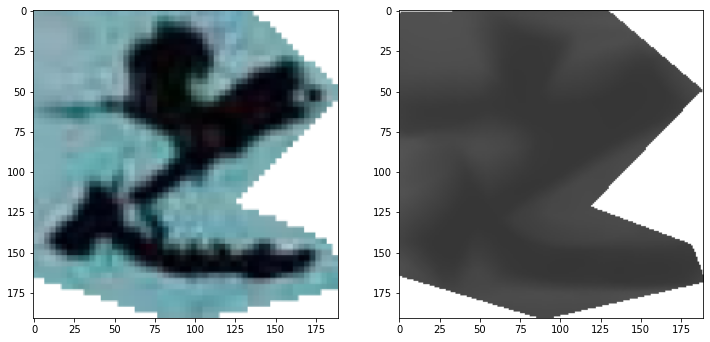

In [94]:
fig, axes = plt.subplots(figsize=(12, 9), nrows=1, ncols=2)
axes[0].imshow(resize_print_img);
axes[1].imshow(depth_dst);

In [7]:
def get_registered_pair(print_img_path, depth_img_path, via_json_path, anno_register_path, save_dir, expand_area=True, expand_ratio=0.1):
    save_dir = os.path.join(save_dir, Path(via_json_path).stem)
    Path(str(save_dir)).mkdir(parents=True, exist_ok=True)
    print_img = cv2.imread(print_img_path)
    depth_img = cv2.imread(depth_img_path)
    [np_src_point_list, np_dest_point_list] = get_point_from_via_file(via_json_path)
    
    dest_poly_points_list, origin_poly_points_list = mapping(anno_register_path, np_src_point_list, np_dest_point_list)
    if expand_area:
        dest_poly_points_list = expand_polygon(dest_poly_points_list)
    rotated_print_img, M_print = get_rotated_img(print_img, np_src_point_list)
    rotated_depth_img, M_depth = get_rotated_img(depth_img, np_dest_point_list)
    for index, dest_poly in enumerate(dest_poly_points_list):
        dest_transform_poly_points = get_rotation_points(dest_poly, M_depth)
        depth_dst = crop_img(rotated_depth_img, dest_transform_poly_points)
        
        original_transform_poly_points = get_rotation_points(origin_poly_points_list[index], M_print)
        print_dst = crop_img(rotated_print_img, original_transform_poly_points)
        height, width = depth_dst.shape[:2]
        try:
            print_dst = np.array(print_dst).astype('uint8')
            resize_print_img = cv2.resize(print_dst, (width, height), interpolation = cv2.INTER_AREA)
            concated_img = cv2.hconcat([resize_print_img, depth_dst])
            cv2.imwrite(str(os.path.join(save_dir, f"{index}.png")), concated_img)
        except Exception as e:
            continue

In [8]:
def rotate_anno_point_list(origin_poly_points_list, M_print):
    new_origin_poly_points_list = []
    for poly_points in origin_poly_points_list:
        new_origin_poly_points_list.append(get_rotation_points(poly_points, M_print))
    return new_origin_poly_points_list
        
def get_registered_pair_v2(print_img_path, depth_img_path, via_json_path, anno_register_path, save_dir, expand_area=True, expand_ratio=0.1):
    save_dir = os.path.join(save_dir, Path(via_json_path).stem)
    Path(str(save_dir)).mkdir(parents=True, exist_ok=True)
    print_img = cv2.imread(print_img_path)
    depth_img = cv2.imread(depth_img_path)
    [np_src_point_list, np_dest_point_list] = get_point_from_via_file(via_json_path)
    rotated_print_img, M_print = get_rotated_img(print_img, np_src_point_list)
    rotated_depth_img, M_depth = get_rotated_img(depth_img, np_dest_point_list)
    np_src_point_list = get_rotation_points(np_src_point_list, M_print)
    np_dest_point_list = get_rotation_points(np_dest_point_list, M_depth)
    origin_poly_points_list = get_bboxes_from_2d_anno(anno_register_path)
    origin_poly_points_list = rotate_anno_point_list(origin_poly_points_list, M_print)
    dest_poly_points_list = mapping_v2(origin_poly_points_list, np_src_point_list, np_dest_point_list)
    if expand_area:
        dest_poly_points_list = expand_polygon(dest_poly_points_list)
  
    for index, dest_poly in enumerate(dest_poly_points_list):
        # dest_transform_poly_points = get_rotation_points(dest_poly, M_depth)
        depth_dst = crop_img(rotated_depth_img, dest_poly)
        
        #original_transform_poly_points = get_rotation_points(origin_poly_points_list[index], M_print)
        print_dst = crop_img(rotated_print_img, origin_poly_points_list[index])
        height, width = depth_dst.shape[:2]
        try:
            print_dst = np.array(print_dst).astype('uint8')
            resize_print_img = cv2.resize(print_dst, (width, height), interpolation = cv2.INTER_AREA)
            concated_img = cv2.hconcat([resize_print_img, depth_dst])
            cv2.imwrite(str(os.path.join(save_dir, f"{index}.png")), concated_img)
        except Exception as e:
            continue

In [9]:
print_img_path_list = ["08360b_2.jpg", "08360a_3.jpg", "08465b_3.jpg", "08465a_4.jpg", "24539a_2.jpg", "24539b_2.jpg", "25476a_2.jpg", "25476b_5.jpg", "26774a_4.jpg", "26774b_3.jpg", "29141b_4.jpg", "29141a_4.jpg"]
depth_img_path_list = ["08360_kho_khuon_in_2_r_depth.png", "08360_kho_khuon_in_1_r_depth.png", "08465_kho_khuon_in_1_r_depth.png", "08465_kho_khuon_in_2_r_depth.png", "24539_kho_khuon_in_1_r_depth.png", "24539_kho_khuon_in_2_r_depth.png", "25476_kho_khuon_in_1_r_depth.png", "25476_kho_khuon_in_2_r_depth.png", "26774_kho_khuon_in_1_r_depth.png", "26774_kho_khuon_in_2_r_depth.png", "29141_kho_khuon_in_1_r_depth.png", "29141_kho_khuon_in_2_r_depth.png"]
via_json_path_list = ["08360b_2.json", "08360a_1.json", "08465_1.json", "08465_2.json", "24539_1.json", "24539_2.json", "25476_1.json", "25476_2.json", "26774_1.json", "26774_2.json", "29141_1.json", "29141_2.json"]
anno_register_path_list = ["08360b_2.json", "08360a_3.json", "08465b_3.json", "08465a_4.json", "24539a_2.json", "24539b_2.json", "25476a_2.json", "25476b_5.json", "26774a_4.json", "26774b_3.json", "29141b_4.json", "29141a_4.json"]

In [10]:
print(len(print_img_path_list))
print(len(depth_img_path_list))
print(len(via_json_path_list))
print(len(anno_register_path_list))

12
12
12
12


In [11]:
for index in range(len(print_img_path_list)):
    try:
        print_img_path = f"/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/mocban_img_2d/{print_img_path_list[index]}"
        depth_img_path = f"/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/depths/{depth_img_path_list[index]}"
        via_json_path = f"/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/registering_points_anno/{via_json_path_list[index]}"
        anno_register_path = f"/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/anno_2d/{anno_register_path_list[index]}"
        # print(print_img_path, depth_img_path, via_json_path)
        save_dir = f"/mnt/hdd/thuonglc/mocban/taming-transformers/data/woodblock_components/kho_khuon_in_dataset/concated_imgs/"
        get_registered_pair(print_img_path, depth_img_path, via_json_path, anno_register_path, save_dir, expand_area=False)
    except Exception as e:
        print(e)
        continue

/tmp/ipykernel_253670/1550355838.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np_bboxes = np.asarray(bboxes_list)
